# Microcontroller Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 45.7MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 1.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=9378ab6b33c28d3b5a84173db2e61e656554cc9997d6e883d9d545168620f1b4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-o3kyp56w
  Running command git 

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 872kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200325-cp36-none-any.whl size=38930 sha256=d23d231af0b3c3d358a7e6f23748802ac7754b82c0168708fc6d004ab78c1cff
  Stored in directory: /root/.cache/pip/wheels/58/4f/d1/6b0ada294145df5fe73092d9849d27be5b5b720fd8cfdd1b98
Successfully built fvcore


## Get data

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
!wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
!unzip microcontroller_segmentation_data.zip
!ls

--2020-03-30 13:46:07--  https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/master/microcontroller_segmentation_data.zip [following]
--2020-03-30 13:46:08--  https://raw.githubusercontent.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/master/microcontroller_segmentation_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17521676 (17M) [application/zip]
Saving to: ‘microcontroller_segmentation_

In [ ]:
!ls 'Microcontroller Segmentation'

labelme2coco.py  test  test.json  train  train.json


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [ ]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"microcontroller_{d}", {}, f"Microcontroller Segmentation/{d}.json", f"Microcontroller Segmentation/{d}")

WARNING [03/30 13:46:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/30 13:46:18 d2.data.datasets.coco]: Loaded 142 images in COCO format from Microcontroller Segmentation/train.json


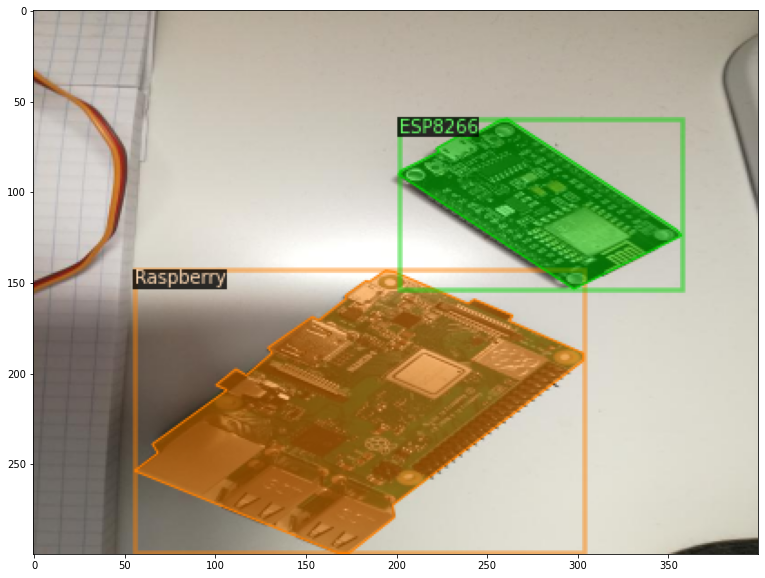

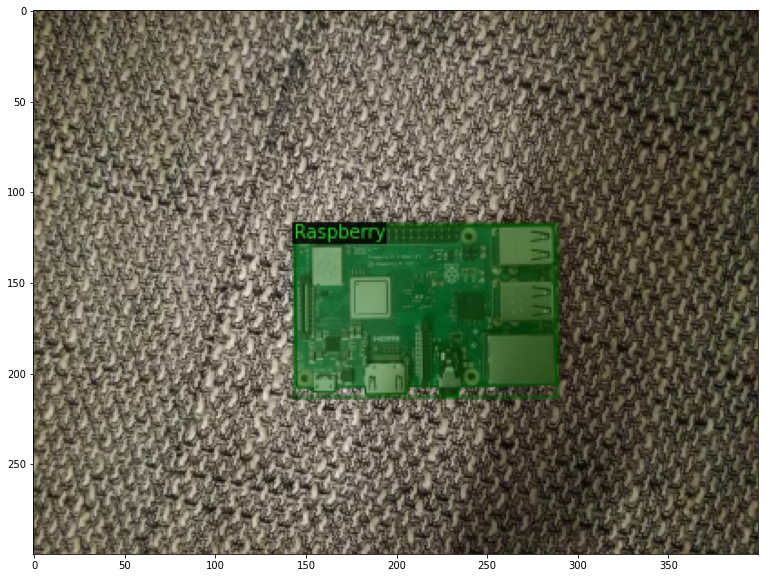

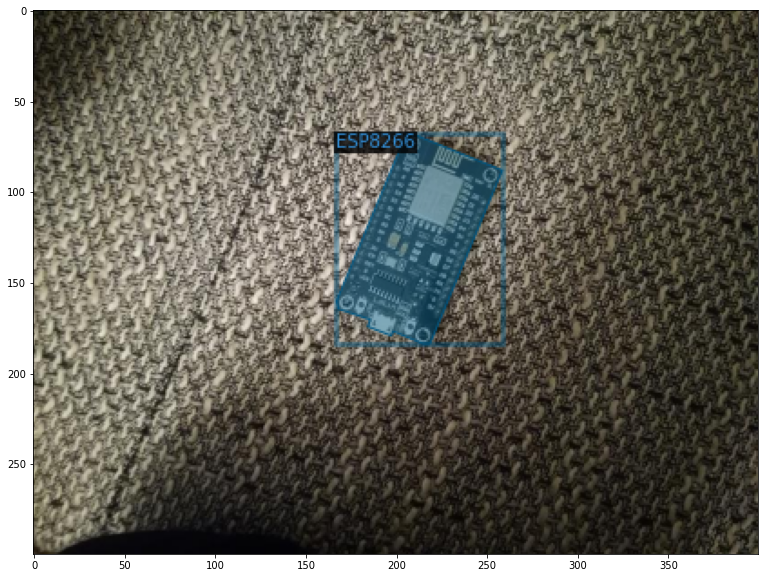

In [ ]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("microcontroller_train")
microcontroller_metadata = MetadataCatalog.get("microcontroller_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/30 13:46:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:15, 11.3MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (5, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (16, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (4,) in the model! Skipped.


[03/30 13:46:41 d2.engine.train_loop]: Starting training from iteration 0
[03/30 13:47:07 d2.utils.events]:  eta: 0:21:06  iter: 19  total_loss: 2.503  loss_cls: 1.665  loss_box_reg: 0.139  loss_mask: 0.690  loss_rpn_cls: 0.006  loss_rpn_loc: 0.004  time: 1.3051  data_time: 0.0176  lr: 0.000005  max_mem: 2345M
[03/30 13:47:33 d2.utils.events]:  eta: 0:20:47  iter: 39  total_loss: 2.340  loss_cls: 1.502  loss_box_reg: 0.137  loss_mask: 0.684  loss_rpn_cls: 0.005  loss_rpn_loc: 0.003  time: 1.3030  data_time: 0.0053  lr: 0.000010  max_mem: 2345M
[03/30 13:48:00 d2.utils.events]:  eta: 0:20:26  iter: 59  total_loss: 1.963  loss_cls: 1.161  loss_box_reg: 0.130  loss_mask: 0.677  loss_rpn_cls: 0.007  loss_rpn_loc: 0.004  time: 1.3058  data_time: 0.0064  lr: 0.000015  max_mem: 2345M
[03/30 13:48:28 d2.utils.events]:  eta: 0:20:19  iter: 79  total_loss: 1.593  loss_cls: 0.791  loss_box_reg: 0.134  loss_mask: 0.661  loss_rpn_cls: 0.003  loss_rpn_loc: 0.003  time: 1.3284  data_time: 0.0062  lr:

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("microcontroller_test", )
predictor = DefaultPredictor(cfg)

WARNING [03/30 14:09:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/30 14:09:36 d2.data.datasets.coco]: Loaded 142 images in COCO format from Microcontroller Segmentation/train.json


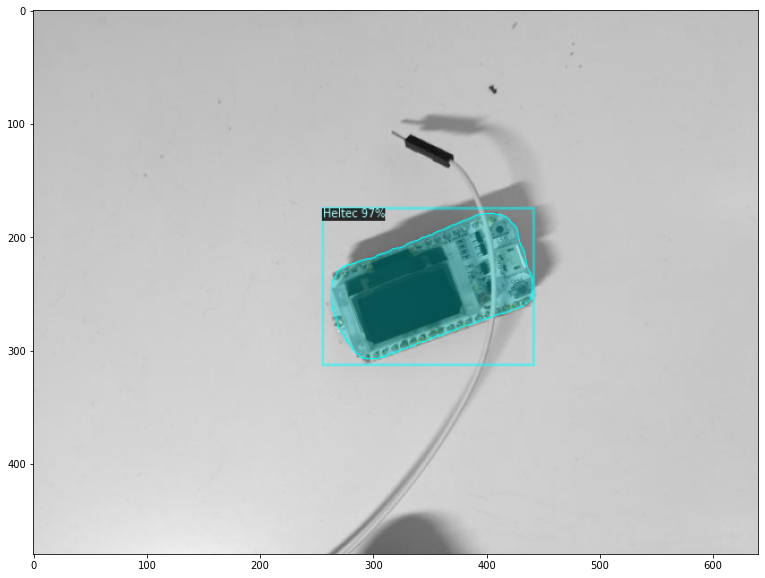

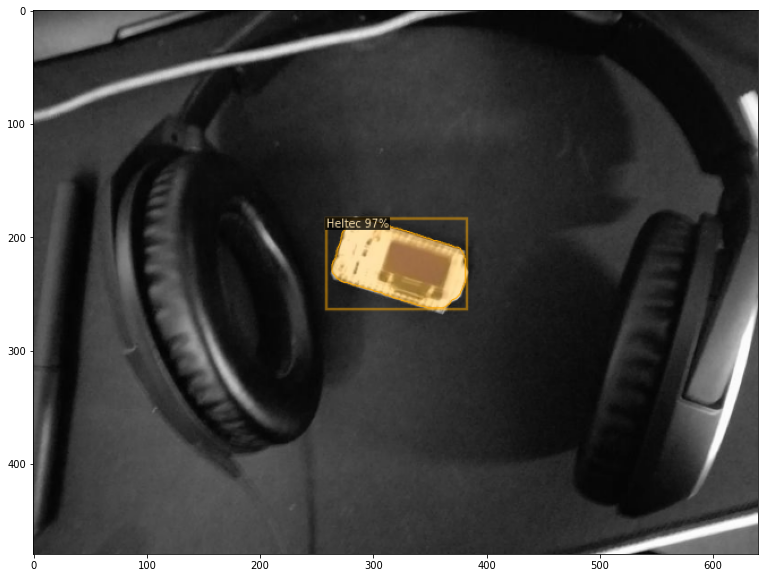

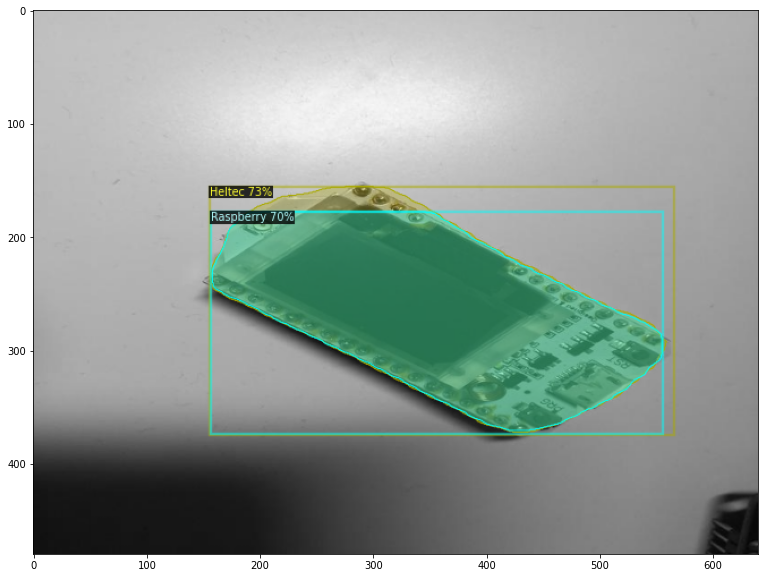

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("microcontroller_train")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()